In [1]:
import os
import sys
import subprocess
import shutil
import pandas as pd
import numpy as np
import pysam
import glob

import matplotlib.pyplot as plt
import seaborn as sns

# The target barcodes

In [2]:
# load the barcodes of interest
fpath = "../2000_closest.fasta"

def load_fasta_barcodes(fpath):
    """A function to read the barcodes from a fasta
    file """
    barcodes = []
    
    for line in open(fpath):
        if not line.startswith(">"):
            continue
        else:
            barcode = line.replace(">", '').split(":")[0]
            barcodes.append(barcode)
    return barcodes
    
barcodes = load_fasta_barcodes(fpath)
print(len(barcodes))

2000


# AS Test runs

In [3]:
def process_demultiplexing_results(outpath, sample_size=100000):
    """Processes demultiplexing results from a given output path.

    Args:
        outpath (str): The base output directory containing the results.
        sample_size (int): The maximum number of rows to read from each file.

    Returns:
        pandas.DataFrame: The processed and concatenated DataFrame.
    """

    df = []
    for test_run in os.listdir(outpath):
        if not test_run.endswith("putative_bc.csv"):
            continue

        fpath = os.path.join(outpath, test_run)  # Use os.path.join for portability

        if sample_size is None:
            tmp = pd.read_csv(fpath)
        else:
            tmp = pd.read_csv(fpath, nrows=sample_size)
        tmp['run'] = test_run.replace(".csv", "").replace("putative_bc", "")[:-1]
        df.append(tmp)

    df = pd.concat(df)
    df['direction'] = np.sign(df['umi_end'])
    df['direction'] = df['direction'].fillna('0')  # Fill with string '0' for consistency
    print(f"{df.shape=}")
    return df  # Return the processed DataFrame

outpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/adaptive_sampling/demultiplexing_results/"
as_df = process_demultiplexing_results(outpath, sample_size=None)
as_df['set'] = 'AS'
print(f"{as_df.shape=}")
as_df.head()

df.shape=(13687112, 9)
as_df.shape=(13687112, 10)


,read_id,putative_bc,putative_bc_min_q,putative_umi,umi_end,pre_bc_flanking,post_umi_flanking,run,direction,set
0,3969df98-889d-485f-9a9a-890252b5d704,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024,0,AS
1,6872bb41-6952-41da-95ce-beab6596f289,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024,0,AS
2,8965025d-cdf9-4708-8a40-ec6650980eda,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024,0,AS
3,88617e22-13ee-437f-978d-8965ccfb1a2e,TGTGCGGTCGACATTG,5.0,TAGTGGACAGCT,-62.0,CATCT,TTTTT,third_AS_test_03142024,-1.0,AS
4,c0b86fa1-336b-4d7c-b622-6ba70c686665,GATTCTTCAGGACTTG,5.0,ATTTTTCGGCGT,-89.0,GATCT,TTTTT,third_AS_test_03142024,-1.0,AS


# load the sequencing summaries

In [4]:
dpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/adaptive_sampling/experiment_data/"

sdf = []
for test_run in os.listdir(dpath):
    # check if AS summary exists
    as_search = f"{dpath}{test_run}/other_reports/*adaptive_sampling*"
    as_paths = glob.glob(as_search)

    if not len(as_paths) > 0:
        continue

    tmp = pd.read_csv(as_paths[0], usecols=['read_id', 'decision'])
    tmp['run'] = test_run
    sdf.append(tmp)

sdf = pd.concat(sdf)
print(f"{sdf.shape=}")
sdf.head()

sdf.shape=(12491178, 3)


,read_id,decision,run
0,1c3ed62d-34a4-4ff7-bc9c-8d70dc7f9c7c,unblock,2024-04-26-iHSC-AS-6th-Run
1,3e33065a-1f21-40d3-95b9-cef46443d87d,unblock,2024-04-26-iHSC-AS-6th-Run
2,33bd2ea9-d97e-4370-8885-27f0df165477,unblock,2024-04-26-iHSC-AS-6th-Run
3,96890e2d-0a78-449f-b179-0a02fae92349,unblock,2024-04-26-iHSC-AS-6th-Run
4,11c31710-850b-4288-8a81-48052aa53d47,stop_receiving,2024-04-26-iHSC-AS-6th-Run


In [5]:
# merge the decisions
as_df = pd.merge(as_df, sdf,
                 how='left',
                 left_on=['read_id', 'run'],
                 right_on=['read_id', 'run'])

as_df['decision'].value_counts(dropna=False, normalize=True)

NaN               0.386812
unblock           0.378697
no_decision       0.130160
stop_receiving    0.104330
Name: decision, dtype: float64

# Load the Non AS Data

In [6]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/results/HSC/demultiplex/"
seq_df = process_demultiplexing_results(dirpath, sample_size=None) # read all reads
seq_df['set'] = 'Sample'
print(f"{seq_df.shape=}")
seq_df.head()

df.shape=(154894020, 9)
seq_df.shape=(154894020, 10)


,read_id,putative_bc,putative_bc_min_q,putative_umi,umi_end,pre_bc_flanking,post_umi_flanking,run,direction,set
0,dcf36249-ec3f-46eb-ba52-1c25fc42262e,CTCTCTCTCTCTTTTT,8.0,TTTTTTTTTTTT,-41.0,CCTCT,CTTTT,P2r5,-1.0,Sample
1,de97d394-99df-4058-ba80-6b739ec8637f,NaN,NaN,NaN,NaN,NaN,NaN,P2r5,0,Sample
2,3eb0e4f7-8e41-4d2b-9bdc-dfde8be57180,NaN,NaN,NaN,NaN,NaN,NaN,P2r5,0,Sample
3,91ba75ae-f088-40f8-b252-406a10bb697e,NaN,NaN,NaN,NaN,NaN,NaN,P2r5,0,Sample
4,0add03ab-eeae-4ad7-80f9-71314043d2f8,NaN,NaN,NaN,NaN,NaN,NaN,P2r5,0,Sample


# Combine the AS and sequencing runs

In [7]:
df = pd.concat([as_df, seq_df])
print(f"{df.shape=}")

df.head()

df.shape=(170352514, 11)


,read_id,putative_bc,putative_bc_min_q,putative_umi,umi_end,pre_bc_flanking,post_umi_flanking,run,direction,set,decision
0,3969df98-889d-485f-9a9a-890252b5d704,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024,0,AS,NaN
1,6872bb41-6952-41da-95ce-beab6596f289,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024,0,AS,NaN
2,8965025d-cdf9-4708-8a40-ec6650980eda,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024,0,AS,NaN
3,88617e22-13ee-437f-978d-8965ccfb1a2e,TGTGCGGTCGACATTG,5.0,TAGTGGACAGCT,-62.0,CATCT,TTTTT,third_AS_test_03142024,-1.0,AS,NaN
4,c0b86fa1-336b-4d7c-b622-6ba70c686665,GATTCTTCAGGACTTG,5.0,ATTTTTCGGCGT,-89.0,GATCT,TTTTT,third_AS_test_03142024,-1.0,AS,NaN


# add analysis columns

In [8]:
def get_machine_type(run_labels):
  """Categorizes machine types based on names.

  Args:
    run_labels: A list of strings representing the names.

  Returns:
    dict: A dictionary mapping run labels to their machine types ('P2' or 'GridION').
  """

  return {
      name: 'GridION' if 'iHSC' in name or 'Grid' in name else 'P2'
      for name in run_labels
  }
    
df['has_barcode'] = df['putative_bc'].notna()
df['is_target'] = df['putative_bc'].isin(barcodes)
df['correct_direction'] = df['direction'] == 1.0
df['barcodes_correct_direction'] = df['correct_direction'] & df['has_barcode']
df['target_correct_direction'] = df['correct_direction'] & df['is_target']

# map machine type
run_map = get_machine_type(list(df['run'].unique()))
df['machine'] = df['run'].map(run_map)

df.head()

,read_id,putative_bc,putative_bc_min_q,putative_umi,umi_end,pre_bc_flanking,post_umi_flanking,run,direction,set,decision,has_barcode,is_target,correct_direction,barcodes_correct_direction,target_correct_direction,machine
0,3969df98-889d-485f-9a9a-890252b5d704,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024,0,AS,NaN,False,False,False,False,False,P2
1,6872bb41-6952-41da-95ce-beab6596f289,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024,0,AS,NaN,False,False,False,False,False,P2
2,8965025d-cdf9-4708-8a40-ec6650980eda,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024,0,AS,NaN,False,False,False,False,False,P2
3,88617e22-13ee-437f-978d-8965ccfb1a2e,TGTGCGGTCGACATTG,5.0,TAGTGGACAGCT,-62.0,CATCT,TTTTT,third_AS_test_03142024,-1.0,AS,NaN,True,False,False,False,False,P2
4,c0b86fa1-336b-4d7c-b622-6ba70c686665,GATTCTTCAGGACTTG,5.0,ATTTTTCGGCGT,-89.0,GATCT,TTTTT,third_AS_test_03142024,-1.0,AS,NaN,True,False,False,False,False,P2


In [9]:
df['target_correct_direction'].value_counts(normalize=True)

False    0.975739
True     0.024261
Name: target_correct_direction, dtype: float64

In [10]:
gx = df.groupby(['run', 'set', 'machine']).agg(
    total_reads = ('read_id', 'count'),
    target_correct_direction = ('target_correct_direction', 'sum'),
    has_barcode = ('has_barcode', 'sum'),
    is_target = ('is_target', 'sum'),
    barcodes_correct_direction = ('barcodes_correct_direction', 'sum'),
    correct_direction = ('correct_direction', 'sum'),
).reset_index()

gx.head()

,run,set,machine,total_reads,target_correct_direction,has_barcode,is_target,barcodes_correct_direction,correct_direction
0,2024-04-18-iHSC-3rd-run,AS,GridION,1546993,52750,965679,76464,654891,654891
1,2024-04-22-iHSC-4th-run,AS,GridION,2024974,77378,1357943,113356,917017,917017
2,2024-04-26-iHSC-AS-6th-Run,AS,GridION,1711980,63112,1101321,87547,780041,780041
3,2024-04-26-iHSC-AS-7th-Run,AS,GridION,115033,4110,73835,5646,52290,52290
4,2024-04-26-iHSC-AS-8th-Run-fast,AS,GridION,735209,19249,446524,26503,316160,316160


<Axes: xlabel='set', ylabel='target_correct_direction_percent'>

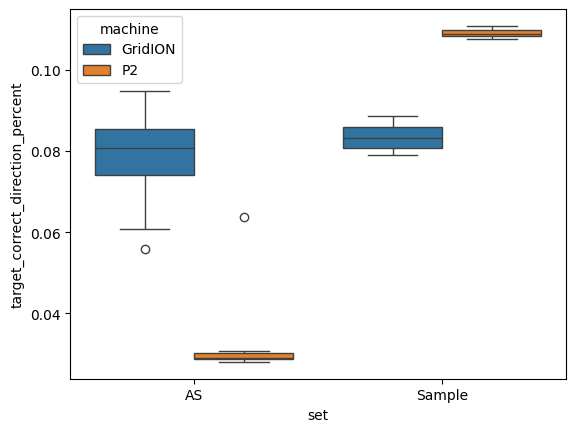

In [11]:
gx['target_correct_direction_percent'] = gx['target_correct_direction'] / gx['barcodes_correct_direction']
sns.boxplot(data=gx,
            x='set',
            y='target_correct_direction_percent',
            hue='machine')

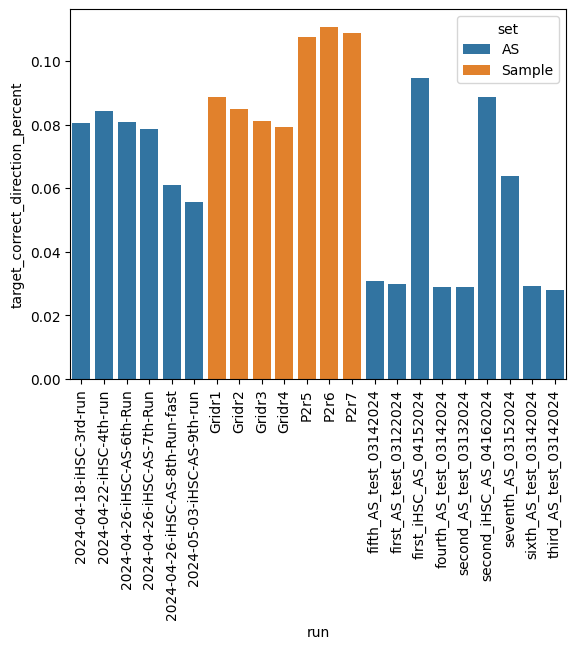

In [14]:

sns.barplot(data=gx,
            x='run',
            y='target_correct_direction_percent',
            hue='set')
plt.gca().tick_params(axis='x', rotation=90)